In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
import csv

# The bathymetry

To be used as a mask for max-heights

Configure the extent 

In [2]:
bathymetry_extent = {
    "xmin" : 90, 
    "xmax" :  325.83,
    "ymin" :  -85,
    "ymax" : 85,
}

In [3]:
nami_extent = {
    "xmin" : 90,
    "xmax" : 325.83,
    "ymin" : -60,
    "ymax" : 70,
}

Bathymetry resolution

Read bathymetry

In [4]:
bathymetry_raw = np.fromfile(f'../../03_biobio2010/data/bathymetry3min',dtype='float64')
bathymetry_shape = np.asarray(bathymetry_raw[:2], dtype=int)    
bathymetry_raw = bathymetry_raw[2:]
bathymetry_raw = bathymetry_raw.reshape(bathymetry_shape)

In [5]:
bathymetry_raw.shape

(3400, 4717)

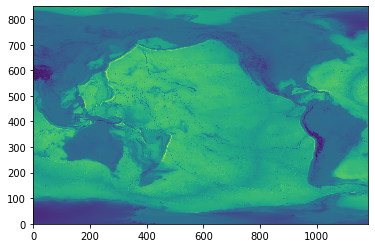

In [6]:
plt.pcolormesh(bathymetry_raw[::4, ::4])

Trim parts of the bathymetry not in the domain of Nami

In [7]:
ds_original = 3

In [8]:
lat_start_index = int((nami_extent["ymin"] - bathymetry_extent["ymin"])/(ds_original/60))
lat_end_index = bathymetry_shape[0] - int((bathymetry_extent["ymax"] - nami_extent["ymax"])/(ds_original/60))
lon_start_index = int((nami_extent["xmin"] - bathymetry_extent["xmin"])/(ds_original/60))
lon_end_index = bathymetry_shape[1] - int((bathymetry_extent["xmax"] - nami_extent["xmax"])/(ds_original/60))
print(f"lat_start_index={lat_start_index}")
print(f"lat_end_index={lat_end_index}")
print(f"lon_start_index={lon_start_index }")
print(f"lon_end_index={ lon_end_index }")

lat_start_index=500
lat_end_index=3100
lon_start_index=0
lon_end_index=4717


In [9]:
skip = 1
bathymetry = bathymetry_raw[lat_start_index:lat_end_index,lon_start_index:lon_end_index]
bathymetry = bathymetry[::skip, ::skip][:,:-1]
nlat, nlon = bathymetry.shape
print(f"nlat = {nlat}, nlon = {nlon}")

nlat = 2600, nlon = 4716


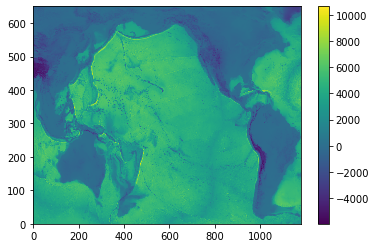

In [10]:
plt.pcolormesh(bathymetry[::4, ::4])
plt.colorbar()

# Read max heights and arrival

In [11]:
def read_large_nami_csv(path):
    reader = csv.reader(open(path))

    for row in reader:
        continue

    return np.array(row, dtype=float)

In [12]:
nami_folder = "../nami"

In [13]:
nlat

2600

In [14]:
hmax_unmasked = read_large_nami_csv(f"{nami_folder}/tlab2D.csv").reshape((nlat, -1))

In [15]:
harr_unmasked = read_large_nami_csv(f"{nami_folder}/tlab2D (1).csv").reshape((nlat,-1))

harr = np.ma.masked_where(bathymetry<500, harr_unmasked)
hmax = np.ma.masked_where(bathymetry<10, hmax_unmasked)

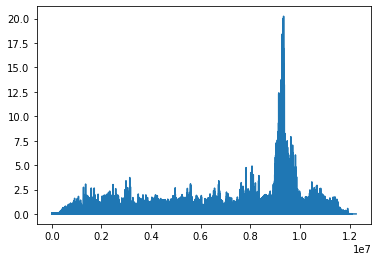

In [16]:
plt.plot(hmax_unmasked.ravel())

In [17]:
np.percentile(hmax_unmasked.ravel(), 90)

0.22182858288288115

In [18]:
x = np.linspace(nami_extent["xmin"], nami_extent["xmax"], nlon)
y = np.linspace(nami_extent["ymin"], nami_extent["ymax"], nlat)
x, y = np.meshgrid(x, y)

Pois locations

In [19]:
[21418,32411,51407,55012]

[21418, 32411, 51407, 55012]

In [20]:
pois={
    21414: [178.219,48.968],
    21419: [155.717,44.435],
    21401: [152.583,42.617],
    21418: [148.645,38.727],
    21413: [152.132,30.533],
    52403: [145.52,4.02],
    52406: [164.977,-5.307],
    55012: [158.453,-15.664],
    51425: [183.68,-9.517],
    51407: [203.455,19.57],
    46404: [231.267,45.853],
    46407: [231.168,42.682],
    46411: [232.933,39.333],
    46412: [239.437,32.492],
    43412: [253.03300000000002,16.045],
    43413: [259.91700000000003,11.012],
    32411: [269.12,4.953],
    32412: [273.626,-17.984],
    32413: [266.483,-7.406],
    32401: [286.579,-20.474],
}
darts_ids = [21413, 32412, 43412, 46404, 46407, 46411, 46412, 51425, 52403]# [21418,32411,51407,55012]
# darts_ids = [21413, 32412, 43412, 46404, 46407, 46411, 46412, 51425, 52403, 21418,32411,51407,55012]

In [21]:
dart_locations = np.array(list(pois.values()))

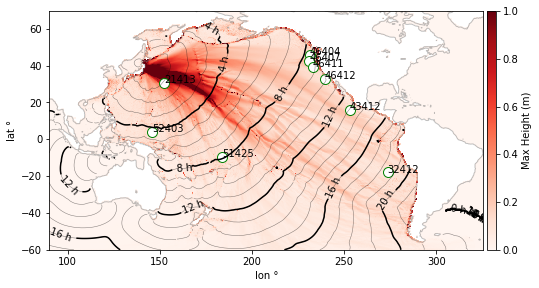

In [22]:
s = 10 #skip size


f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

p = ax1.pcolormesh(x[::s,::s],y[::s,::s],hmax[::s,::s],vmax=1,vmin=0, cmap=plt.cm.Reds, shading="nearest")
divider = make_axes_locatable(ax1)

for  dart in darts_ids:
    
    [lon, lat] = pois[dart]
    ax1.scatter([lon],[lat],color='white',edgecolor='green',marker='o', s=100)
    ax1.annotate('%s'%dart, [lon+0.1,lat])
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = f.colorbar(p,cax)
cbar.set_label('Max Height (m)')

ax1.contour(x[::s,::s],y[::s,::s], bathymetry[::s,::s], [10], linewidths=1, alpha=0.5, colors='grey')
CS = ax1.contour(x[::s,::s],y[::s,::s],harr[::s,::s]/60/60,np.arange(0,24,4),colors='k')
ax1.clabel(CS, inline=1, fontsize=10, fmt='%i h')
ax1.contour(x[::s,::s],y[::s,::s],harr[::s,::s]/60/60,
            np.arange(0,24,1),colors='k', linewidths=0.5, alpha=0.5)

ax1.set_aspect(1)
ax1.set_xlabel('lon °')
ax1.set_ylabel('lat °')
f.savefig('energy2010.png',dpi=300,bbox_inches='tight')

In [23]:
x.min(),x.max()

(90.0, 325.83)